# Projekt: Situacijsko zavedanje pametnega doma

Več informacij: README.txt

C:\Users\Leon\AppData\Local\Temp\ipykernel_15128\1386705189.py:6: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("PametniDomPodatki\HomeC.csv")


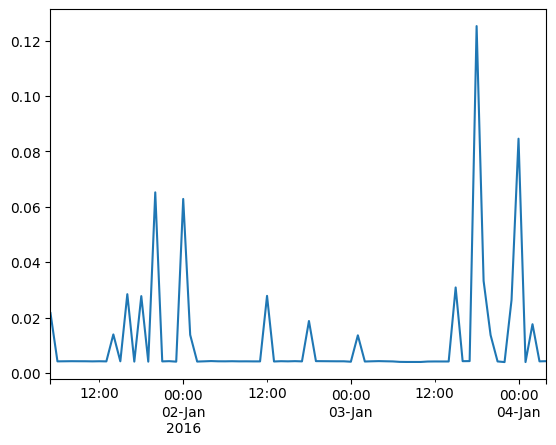

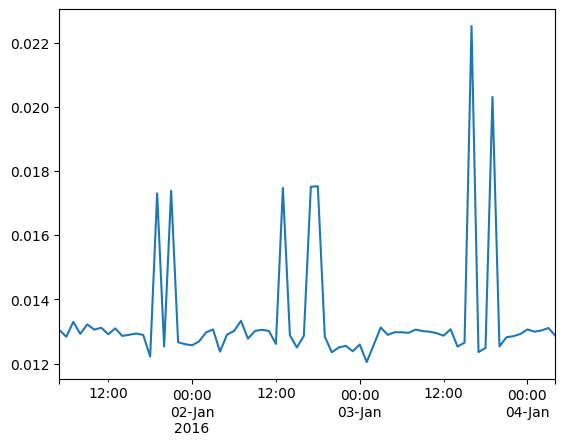

<Axes: >

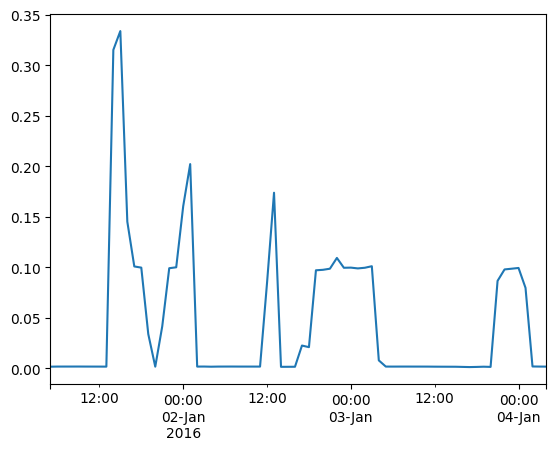

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Uvoz podatkov
dataset = pd.read_csv("PametniDomPodatki\HomeC.csv")
dataset.columns

# Pretvorba datuma v indeks
time_index = pd.date_range('2016-01-01 05:00', periods=len(dataset),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
dataset = dataset.set_index(time_index)
#dataset = dataset.drop(['time'], axis=1)
dataset.iloc[np.r_[0:5,-5:0]].iloc[:,0]

# # Izpis prvih 5 vrstic
# print(dataset.head())

# Prikaz povprečenih podatkov za prve tri dni
dataset['Microwave [kW]'].resample("h").mean().iloc[:72].plot()
plt.show()
dataset['Garage door [kW]'].resample("h").mean().iloc[:72].plot()
plt.show()
dataset['Living room [kW]'].resample("h").mean().iloc[:72].plot()

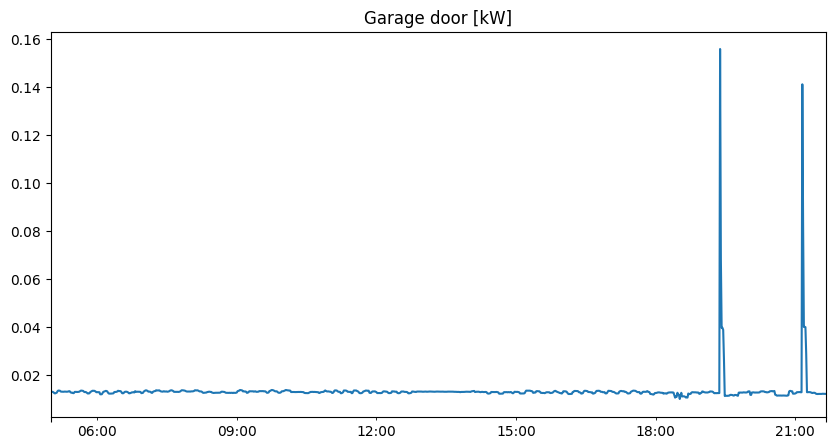

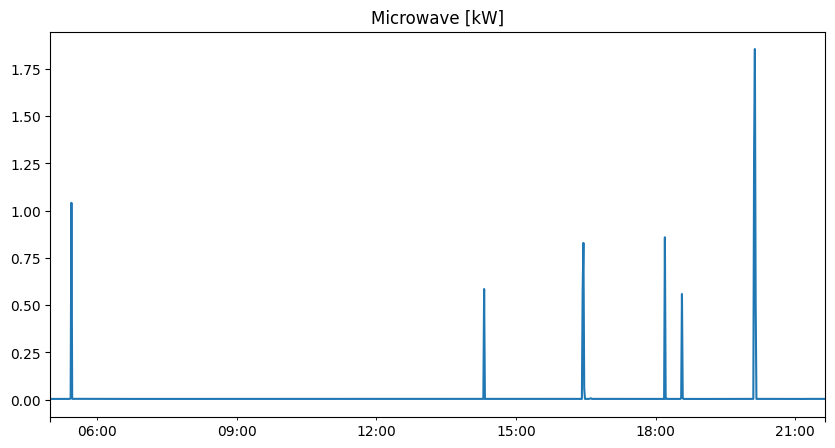

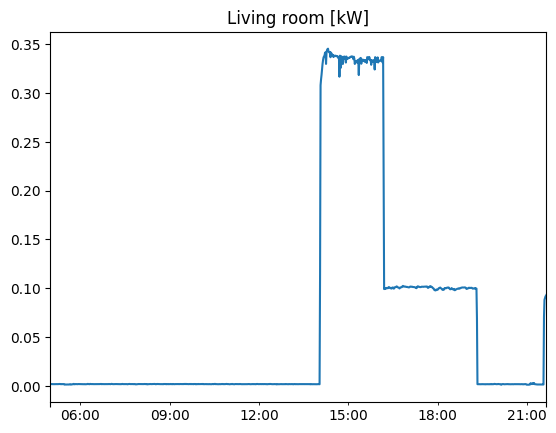

In [2]:
# Prikaži podatke za prvih 1000 vzorcev
st_vzorcev=1000
dataset['Garage door [kW]'].iloc[:st_vzorcev].plot(figsize=(10,5))
plt.title("Garage door [kW]")
plt.show()
dataset['Microwave [kW]'].iloc[0:st_vzorcev].plot(figsize=(10,5))
plt.title("Microwave [kW]")
plt.show()
dataset['Living room [kW]'].iloc[:st_vzorcev].plot()
plt.title("Living room [kW]")
plt.show()

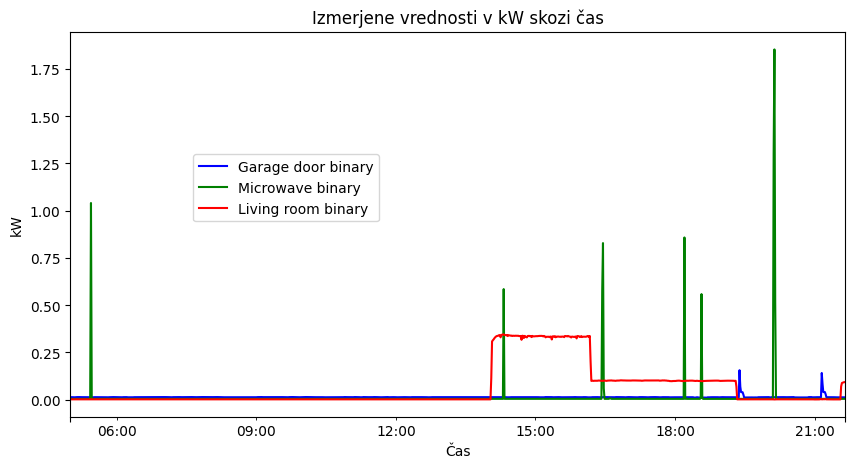

In [3]:
# Prikaz vseh porabnikov za prvih 1000 vzorcev
vzorci = np.r_[0:1000]
dataset['Garage door [kW]'].iloc[vzorci].plot(color='blue', figsize=(10,5), label='Garage door binary')
#plt.title("Garage door binary")
#plt.show()
dataset['Microwave [kW]'].iloc[vzorci].plot(color='green', label='Microwave binary')
#plt.title("Microwave binary")
#plt.show()
dataset['Living room [kW]'].iloc[vzorci].plot(color='red', label='Living room binary')
#plt.title("Living room binary")
plt.title("Izmerjene vrednosti v kW skozi čas")
plt.xlabel("Čas")
plt.ylabel("kW")
plt.legend(loc='upper left',  bbox_to_anchor=(0.15, 0.7))

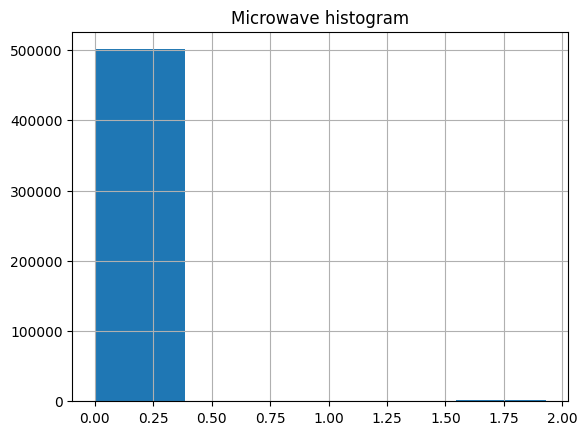

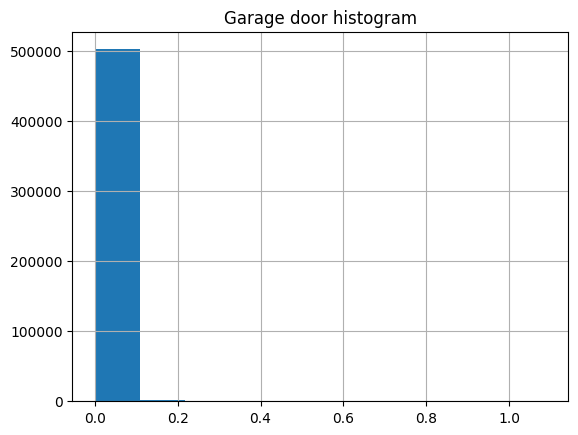

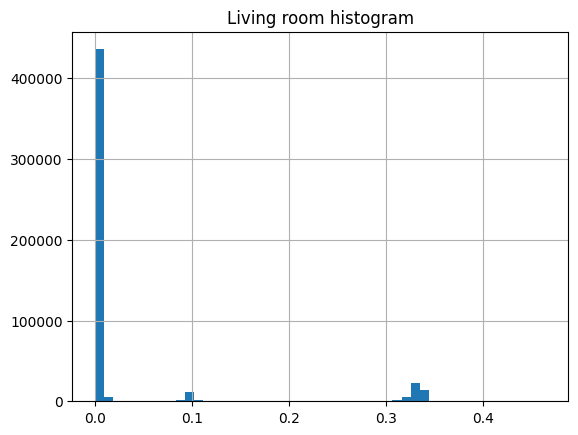

In [14]:
# Odstranjevanje šuma: histogrami
dataset['Microwave [kW]'].hist(bins=5)
plt.title('Microwave histogram')
plt.show()
dataset['Garage door [kW]'].hist(bins=10)
plt.title('Garage door histogram')
plt.show()
dataset['Living room [kW]'].hist(bins=50)
plt.title('Living room histogram')
plt.show()


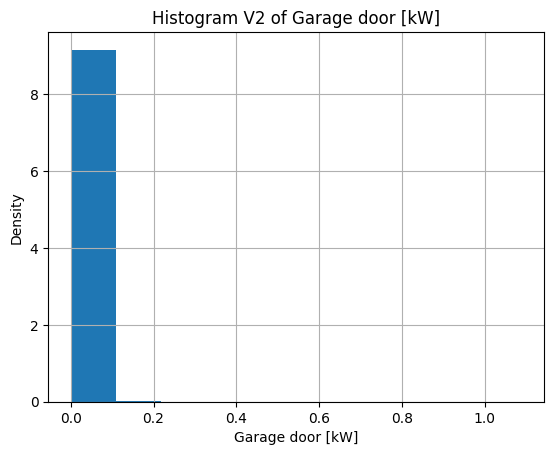

In [15]:
# I tried to get more precise treshold for garage door. 
# But histogram aproach, was not the best so I get treshold from plot. of values.dataset
# Plot histogram with more bins and specified range
min_value = dataset['Garage door [kW]'].min()
max_value = dataset['Garage door [kW]'].max()
dataset['Garage door [kW]'].hist(bins=10, range=(min_value, max_value), density=True)
plt.xlabel('Garage door [kW]')
plt.ylabel('Density')
plt.title('Histogram V2 of Garage door [kW]')
plt.show()

In [16]:
# Binarizacija podatkov za naprave
threshold_microwave = 0.5
threshold_door = 0.025
threshold_living_room = 0.025

dataset['Microwave Binary'] = (dataset['Microwave [kW]'] > threshold_microwave).astype(int)
dataset['Door Binary'] = (dataset['Garage door [kW]'] > threshold_door).astype(int)
dataset['Living Room Binary'] = (dataset['Living room [kW]'] > threshold_living_room).astype(int)

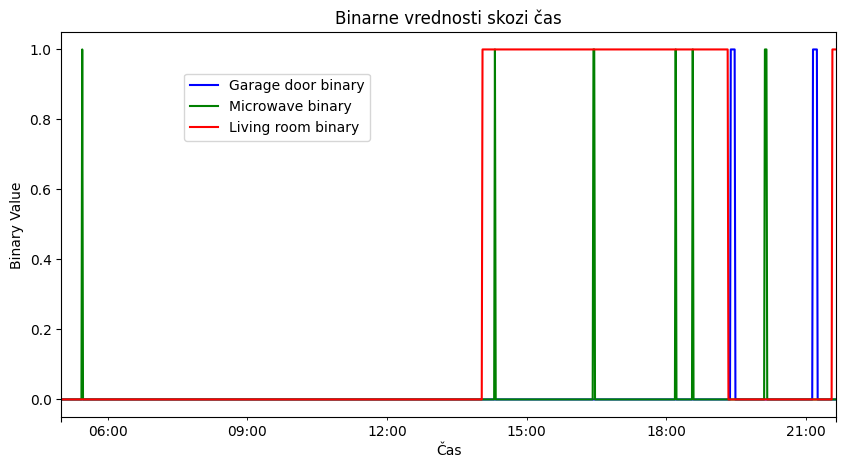

In [17]:
# Plot binary values
vzorci = np.r_[0:1000]
dataset['Door Binary'].iloc[vzorci].plot(color='blue', figsize=(10,5), label='Garage door binary')
#plt.title("Garage door binary")
#plt.show()
dataset['Microwave Binary'].iloc[vzorci].plot(color='green', label='Microwave binary')
#plt.title("Microwave binary")
#plt.show()
dataset['Living Room Binary'].iloc[vzorci].plot(color='red', label='Living room binary')
#plt.title("Living room binary")
plt.title("Binarne vrednosti skozi čas")
plt.xlabel("Čas")
plt.ylabel("Binary Value")
plt.legend(loc='lower left',  bbox_to_anchor=(0.15, 0.7))


In [18]:
# Testing
#dataset['Door Binary'].iloc[0:10000].plot()
#dataset['Microwave Binary'].iloc[0:500000].plot()


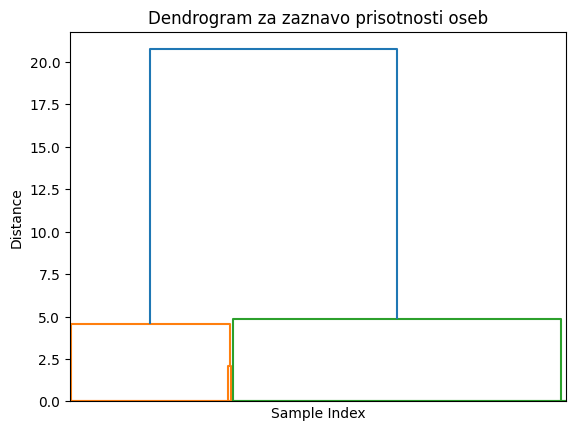

In [20]:
# Hierarhično grozdenje - Dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Ustvarimo matriko značilnosti za clustering
features = dataset[['Microwave Binary', 'Living Room Binary', 'Door Binary']][0:1000]

# Izvedemo hierarhično grozdenje
Z = linkage(features, method='ward')

# Narišemo dendrogram
plt.figure()
dendrogram(Z, no_labels=True)
plt.title("Dendrogram za zaznavo prisotnosti oseb")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


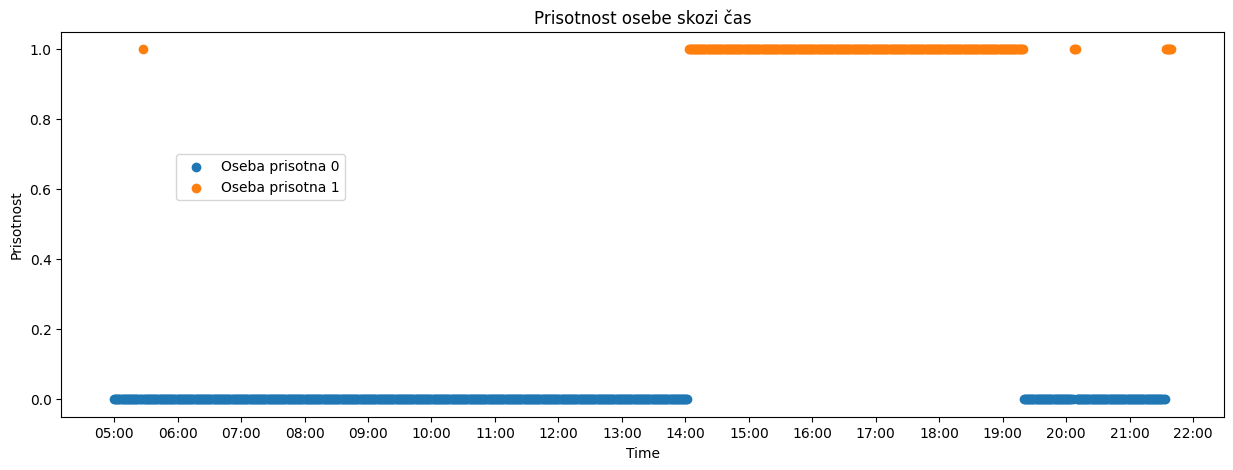

In [21]:
# Hierarhično grozdenje - Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
import matplotlib.dates as mdates

features = dataset[['Microwave Binary', 'Living Room Binary', 'Door Binary']][0:1000]

# Ustvarimo model za grozdenje in določimo ševilo clustrov na podlagi dendrograma
st_clustrov = 2
model = AgglomerativeClustering(n_clusters=st_clustrov, linkage='ward')
model_fit = model.fit(features)

labels = model.fit_predict(features)
#print(labels)

# Dodajanje oznak grozdov v podnabor podatkov
subset = dataset[0:1000].copy()
subset['Cluster'] = labels

# Vizualizacija grozdov skozi čas
plt.figure(figsize=(15, 5))
for cluster in range(st_clustrov):
    cluster_data = subset[subset['Cluster'] == cluster]
    plt.scatter(cluster_data.index, [cluster] * len(cluster_data), label=f'Oseba prisotna {cluster}')

# Formatting the x-axis to show time in "hh:mm"
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))

plt.xlabel('Time')
plt.ylabel('Prisotnost')
plt.title('Prisotnost osebe skozi čas')
plt.legend(bbox_to_anchor=(0.25, 0.7))
plt.show()

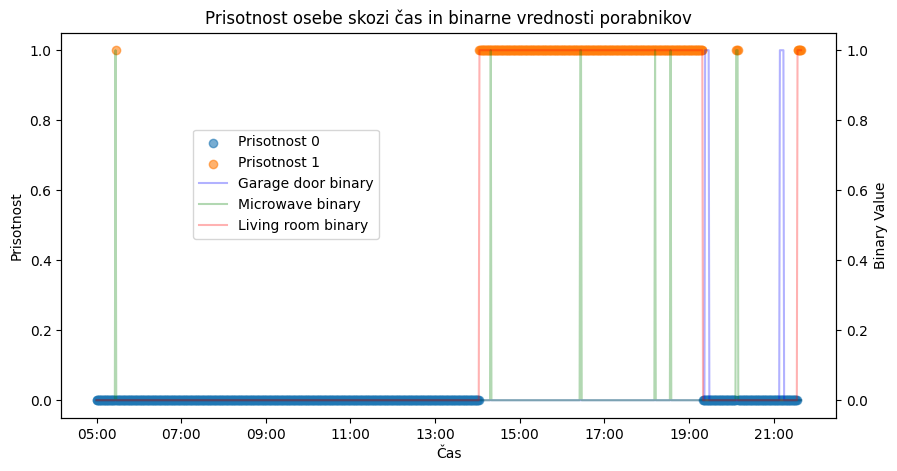

In [23]:
# Prikaz prisotnosti osebe v domu in binarnih vrednosti skozi čas

# Ustvarimo sliko in osi
fig, ax1 = plt.subplots(figsize=(10, 5))

# Vizualizacija grozdov skozi čas
colors = ['blue', 'green', 'red']
for cluster in range(st_clustrov):
    cluster_data = subset[subset['Cluster'] == cluster]
    ax1.scatter(cluster_data.index, [cluster] * len(cluster_data), label=f'Prisotnost {cluster}', alpha=0.6)

# Formatiranje x-osi za prikaz časa v "hh:mm"
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))

ax1.set_xlabel('Čas')
ax1.set_ylabel('Prisotnost')

# Dodajanje druge osi za binarne vrednosti
ax2 = ax1.twinx()
vzorci = np.r_[0:1000]
ax2.plot(dataset.index[vzorci], dataset['Door Binary'].iloc[vzorci], color='blue', label='Garage door binary', alpha=0.3)
ax2.plot(dataset.index[vzorci], dataset['Microwave Binary'].iloc[vzorci], color='green', label='Microwave binary', alpha=0.3)
ax2.plot(dataset.index[vzorci], dataset['Living Room Binary'].iloc[vzorci], color='red', label='Living room binary', alpha=0.3)

ax2.set_ylabel('Binary Value')

# Formatiranje x-osi za prikaz časa v "hh:mm"
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))

# Dodajanje legende
fig.legend(loc='upper left', bbox_to_anchor=(0.25, 0.7))

plt.title("Prisotnost osebe skozi čas in binarne vrednosti porabnikov")
plt.show()


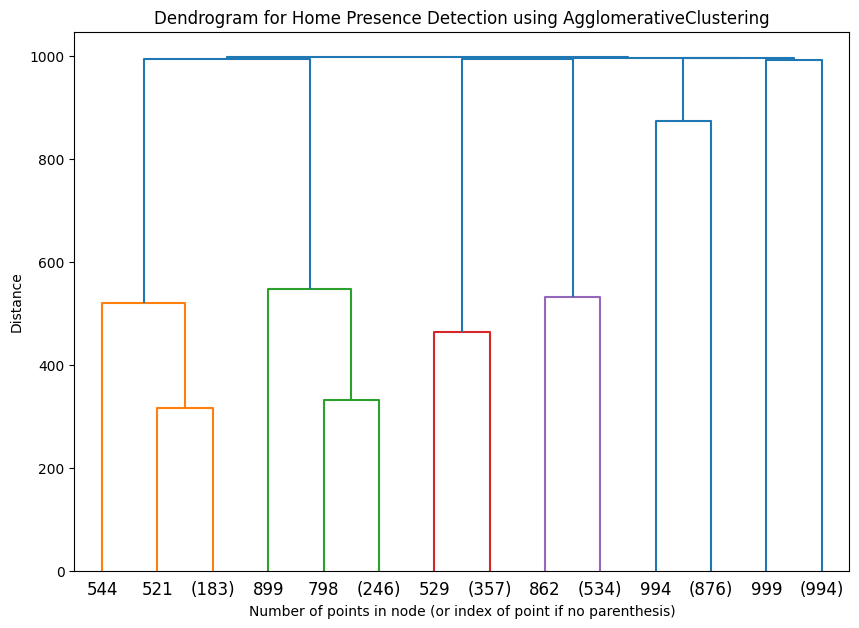